<a href="https://colab.research.google.com/github/soumyaiitkgp/Prediction-and-modelling-of-wave-height/blob/master/LSTM_15days(1day).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
import os
import logging
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

Using TensorFlow backend.


In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Mumbai'  # to set timezone; needed when running on cloud
time.tzset()

In [4]:
from google.colab import files
uploaded = files.upload()

Saving mehamn_data.csv to mehamn_data.csv


In [5]:
data = pd.read_csv('mehamn_data.csv', engine = 'python')
print(data.shape)
data.head()

(174581, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
0,0,1957,9,1,6,3.0,313,0.8,5.2,4.5,310,307,0.1,0.0,242,0.8,5.2,310
1,1,1957,9,1,9,2.0,321,0.8,5.2,4.7,310,318,0.1,0.0,242,0.8,5.2,310
2,2,1957,9,1,12,1.4,337,0.8,5.2,4.8,325,324,0.1,0.0,242,0.7,5.2,325
3,3,1957,9,1,15,2.2,44,0.7,5.2,4.9,325,326,0.1,0.0,242,0.7,5.2,325
4,4,1957,9,1,18,2.7,107,0.7,5.2,4.9,325,327,0.1,0.0,242,0.7,5.2,325


In [0]:
params = {
    "batch_size": 240, #processing the information for 15 days at once
    "epochs": 100,
    "lr": 0.0001,
    "time_steps": 56 #prediction for one week
}

iter_changes = "dropout_layers_0.4_0.4"

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [7]:
for col in data.columns:
    print(col)

Num
YEAR
Month
Day
Hour
wind_WSP
wind_DIR
total_sea_HS
total_sea_TP
total_sea_TM
total_sea_DIRP
total_sea_DIRM
wind_sea_HS
wind_sea_TP
wind_sea_DIRP
swell_HS
swell_TP
swell_DIRP	


In [0]:
d = data

In [9]:
d_train,d_test = train_test_split(d,test_size=0.2, shuffle = False)
print(d_train.shape, d_test.shape)
d_train.head()

(139664, 18) (34917, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
0,0,1957,9,1,6,3.0,313,0.8,5.2,4.5,310,307,0.1,0.0,242,0.8,5.2,310
1,1,1957,9,1,9,2.0,321,0.8,5.2,4.7,310,318,0.1,0.0,242,0.8,5.2,310
2,2,1957,9,1,12,1.4,337,0.8,5.2,4.8,325,324,0.1,0.0,242,0.7,5.2,325
3,3,1957,9,1,15,2.2,44,0.7,5.2,4.9,325,326,0.1,0.0,242,0.7,5.2,325
4,4,1957,9,1,18,2.7,107,0.7,5.2,4.9,325,327,0.1,0.0,242,0.7,5.2,325


In [10]:
print(d_test.shape)
d_test.head()

(34917, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
139664,139664,2005,6,19,6,6.1,113,0.9,6.9,4.7,55,62,0.4,3.6,100,0.8,6.9,55
139665,139665,2005,6,19,9,4.4,107,0.9,6.9,5.0,55,58,0.3,3.2,115,0.9,6.9,55
139666,139666,2005,6,19,12,2.7,105,0.9,6.9,5.4,55,55,0.1,0.0,242,0.8,6.9,55
139667,139667,2005,6,19,15,0.2,293,0.8,6.9,5.5,55,54,0.1,0.0,242,0.8,6.9,55
139668,139668,2005,6,19,18,2.7,275,0.8,6.9,5.6,55,53,0.1,0.0,242,0.8,6.9,55


In [11]:
x_train = d_train
x_test = d_test
print(x_train.shape,x_test.shape)

(139664, 18) (34917, 18)


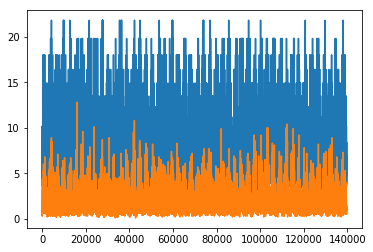

In [12]:
plt.figure()
plt.plot(x_train["total_sea_TP"])
plt.plot(x_train["total_sea_HS"])
plt.show()

In [0]:
#train_cols = ["Month","Day","Hour", "wind_WSP","wind_DIR","total_sea_TP","total_sea_DIRP","wind_sea_TP","wind_sea_DIRP","swell_TP","swell_DIRP"]
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(x_train)
X_test = min_max_scaler.fit_transform(x_test)

(139664, 18)


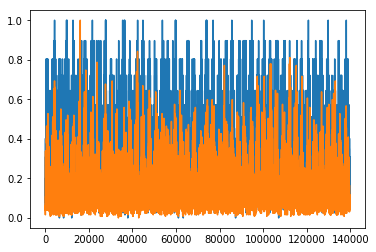

In [14]:
type(X_train)
print(X_train.shape)
plt.figure()
plt.plot(X_train[0:,8])
plt.plot(X_train[0:,7])
plt.show()

In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column, here it will be 9
    # total number of time-series samples would be len(mat) - TIME_STEPS
    #TIME_STEPS = 8 for one day
    #LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.
    #So till now we have a matrix of shape (3, 5), 3 being the time step and 5 being the number of features
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print(dim_0,mat.shape[0])
    for i in tqdm_notebook(range(dim_0)):
        #print(i)
        x[i] = mat[i:TIME_STEPS+i]
        #print(mat[TIME_STEPS+i, y_col_index])
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [17]:
x_t, y_t = build_timeseries(X_train, 9)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

139608 139664



length of time-series i/o (139608, 56, 18) (139608,)


In [18]:
x_temp, y_temp = build_timeseries(X_test, 9)
x_tt = trim_dataset(x_temp, BATCH_SIZE)
y_tt = trim_dataset(y_temp, BATCH_SIZE)
print(y_tt.shape)
print(x_tt.shape)
x_val, x_test_t = np.split(x_tt,2)
y_val, y_test_t = np.split(y_tt,2)
print(x_val.shape, x_test_t.shape)
print(y_val.shape, y_test_t.shape)
#x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
#y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

34861 34917



length of time-series i/o (34861, 56, 18) (34861,)
(34800,)
(34800, 56, 18)
(17400, 56, 18) (17400, 56, 18)
(17400,) (17400,)


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [20]:
OUTPUT_PATH = "D:\Acads\Saud sir"
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=25, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))#, callbacks=[csv_logger])

Train on 139440 samples, validate on 17280 samples
Epoch 1/25
 - 44s - loss: 0.0165 - val_loss: 0.0219
Epoch 2/25
 - 41s - loss: 0.0090 - val_loss: 0.0200
Epoch 3/25
 - 43s - loss: 0.0072 - val_loss: 0.0165
Epoch 4/25
 - 41s - loss: 0.0059 - val_loss: 0.0124
Epoch 5/25
 - 41s - loss: 0.0048 - val_loss: 0.0096
Epoch 6/25
 - 41s - loss: 0.0039 - val_loss: 0.0074
Epoch 7/25
 - 41s - loss: 0.0032 - val_loss: 0.0058
Epoch 8/25
 - 41s - loss: 0.0027 - val_loss: 0.0048
Epoch 9/25
 - 41s - loss: 0.0024 - val_loss: 0.0038
Epoch 10/25
 - 41s - loss: 0.0021 - val_loss: 0.0032
Epoch 11/25
 - 41s - loss: 0.0019 - val_loss: 0.0029
Epoch 12/25
 - 41s - loss: 0.0018 - val_loss: 0.0028
Epoch 13/25
 - 41s - loss: 0.0016 - val_loss: 0.0024
Epoch 14/25
 - 41s - loss: 0.0015 - val_loss: 0.0023
Epoch 15/25
 - 41s - loss: 0.0014 - val_loss: 0.0023
Epoch 16/25
 - 41s - loss: 0.0014 - val_loss: 0.0023
Epoch 17/25
 - 41s - loss: 0.0013 - val_loss: 0.0022
Epoch 18/25
 - 41s - loss: 0.0013 - val_loss: 0.0022
Epoc

In [22]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
from sklearn.metrics import mean_squared_error
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0016345549054994307 (17280,) (17280,)
[0.16815424 0.1813268  0.1993303  0.20748359 0.21794796 0.23027208
 0.2026026  0.1856736  0.17251346 0.1598751  0.15170068 0.13152555
 0.13682622 0.13219717 0.14947256]
[0.16470588 0.17647059 0.18823529 0.2        0.21176471 0.2
 0.17647059 0.16470588 0.14117647 0.12941176 0.10588235 0.10588235
 0.10588235 0.12941176 0.14117647]


In [23]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[4.3293114 4.441278  4.594308  4.6636105 4.7525578 4.8573127 4.6221223
 4.4782257 4.3663645 4.2589383 4.189456  4.017967  4.063023  4.023676
 4.170517 ]
[4.3 4.4 4.5 4.6 4.7 4.6 4.4 4.3 4.1 4.  3.8 3.8 3.8 4.  4.1]


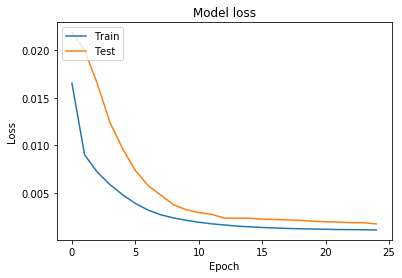

In [24]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

Error is 0.0016345549063840662 (17280,) (17280,)
[0.16815424 0.1813268  0.1993303  0.20748359 0.21794799 0.23027208
 0.2026026  0.1856736  0.17251346 0.15987504 0.15170068 0.13152555
 0.13682622 0.1321972  0.14947256]
[0.16470588 0.17647059 0.18823529 0.2        0.21176471 0.2
 0.17647059 0.16470588 0.14117647 0.12941176 0.10588235 0.10588235
 0.10588235 0.12941176 0.14117647]
[5.2230625 5.28597   5.5447083 5.75959   5.821898  5.8910365 5.765313
 5.9070425 5.735301  5.764744  5.944153  5.7442865 5.6589546 5.3435006
 4.804855  4.281186  4.8497753 4.772757  4.6097445 4.496003  4.600361
 4.7309694 4.647081  4.686697  4.63451   4.8244176 4.614785  4.5705876
 4.5232573 4.5576773 4.697615  4.7987967 5.093298  4.999632  4.794785
 4.865162  4.8725185 4.9881115 4.920193  5.097948  5.5659566 5.763682
 5.635077  5.46184   5.273391  5.1800714 4.341108  4.297287  4.407892
 4.412126  4.602292  4.491288  5.031589  4.5871964 4.2196    4.2461495
 4.764226  4.7036476 5.3764763 5.592389  5.06975   4.6869

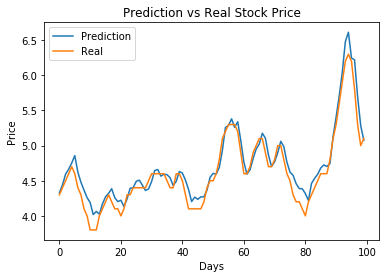

batch_size =  240 timesteps = 56 lr = 0.001 optimizer = Adam No of LSTM layers =2 Dropout=0.4 stateful=True 


In [25]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
#y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[100:200])
print(y_test_t_org[100:200])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
print("batch_size = ",BATCH_SIZE ,"timesteps =",TIME_STEPS , "lr = 0.001","optimizer = Adam", "No of LSTM layers =2","Dropout=0.4","stateful=True ")

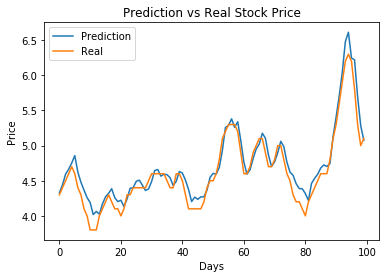

In [26]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

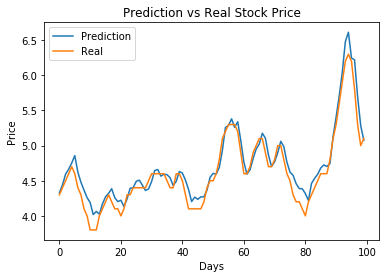

In [27]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

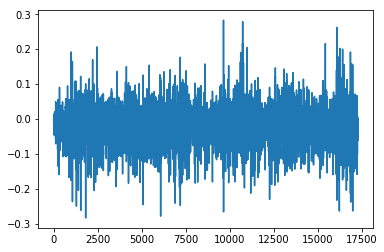

In [28]:
plt.figure()
plt.plot(y_test_t - y_pred)

In [29]:
print(max(y_test_t - y_pred))
print(min(y_test_t - y_pred))
print(type(y_test_t - y_pred))
print(np.mean(y_test_t - y_pred))

0.282709996840533
-0.2836093152270598
<class 'numpy.ndarray'>
-0.014939759239688334
